In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pymc3 as pm
import theano.tensor as tt
import seaborn as sns
from ipywidgets import interactive


In [2]:
from platform import python_version
print('Running on pyMC3 v{}'.format(pm.__version__))
print('Running Python version v{}'.format(python_version()))
print(matplotlib.__version__)

Running on pyMC3 v3.7
Running Python version v3.7.4
3.1.1


## Overdose Model

We assume the following:  

Underlying log rate follows Normal distribution.
$$z_{t} \sim N(\mu, \sigma^{2})$$  

Overdose rate is deterministic variable that exponentiates log rate.  

$$\lambda_{t}^{OD} = \exp(z_{t})$$

Overdoses follows Poission distribution.
$$O_{t} \sim Poi(\lambda_{t}^{OD}N)$$


Our interest is the overdoses. The number of overdoses is not easy to obtain in the real world so we estimate.
We set N=10000.
we obtain 1000 samples of parameters and posterior predictive samples and plot them with the observation.

Think of overdose per a year where t= 1,2,3, ..., 12.
We need a vector of z_t to generate a vector of overdoses. 

We set for our prior parameters: $$\mu=-4, \sigma=1$$.

In [3]:
import random
random.seed(1)
N = 10000
z_t = np.random.normal(loc=-4, scale=1, size = 12)
o_t = np.random.poisson(lam=(np.exp(z_t)*N))
print('Vector z_t: ', z_t)
print('Vector o_t: ', o_t)


Vector z_t:  [-3.30048906 -3.72802883 -4.81683657 -2.90861469 -4.17804388 -3.91329843
 -2.40673299 -5.56982214 -3.45996188 -5.43158707 -3.13840774 -2.40699118]
Vector o_t:  [346 251  77 579 157 227 931  32 327  50 445 947]


Now we have our vector of observations.
Before fitting a model to the data, let's assume that $p(\mu)$ and $p(\sigma^2)$ is noninformative, say uniform.
$$p(\mu) = U(-10, 0)$$  
$$p(\sigma) = U(0, 3)$$  
Let's fit the model to the data o_t.  
Note: prior of variance is inverse Gamma, Cauchy (informative) or Uniform, Half Normal (noninformative).

In [4]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower = -10, upper= 0)
    sigma = pm.Uniform('sigma', lower = 0, upper= 3)
    z_t =pm.Normal('z_t',mu=mu, sigma=sigma, shape = (12,))
    
    x = pm.Poisson('o_t', mu=tt.exp(z_t)*N, shape=(12,), observed=o_t)
    

In [5]:
with model:
    trace =pm.sample(1000)
    ppc = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [z_t, sigma, mu]
100%|██████████| 2000/2000 [00:01<00:00, 1342.02it/s]


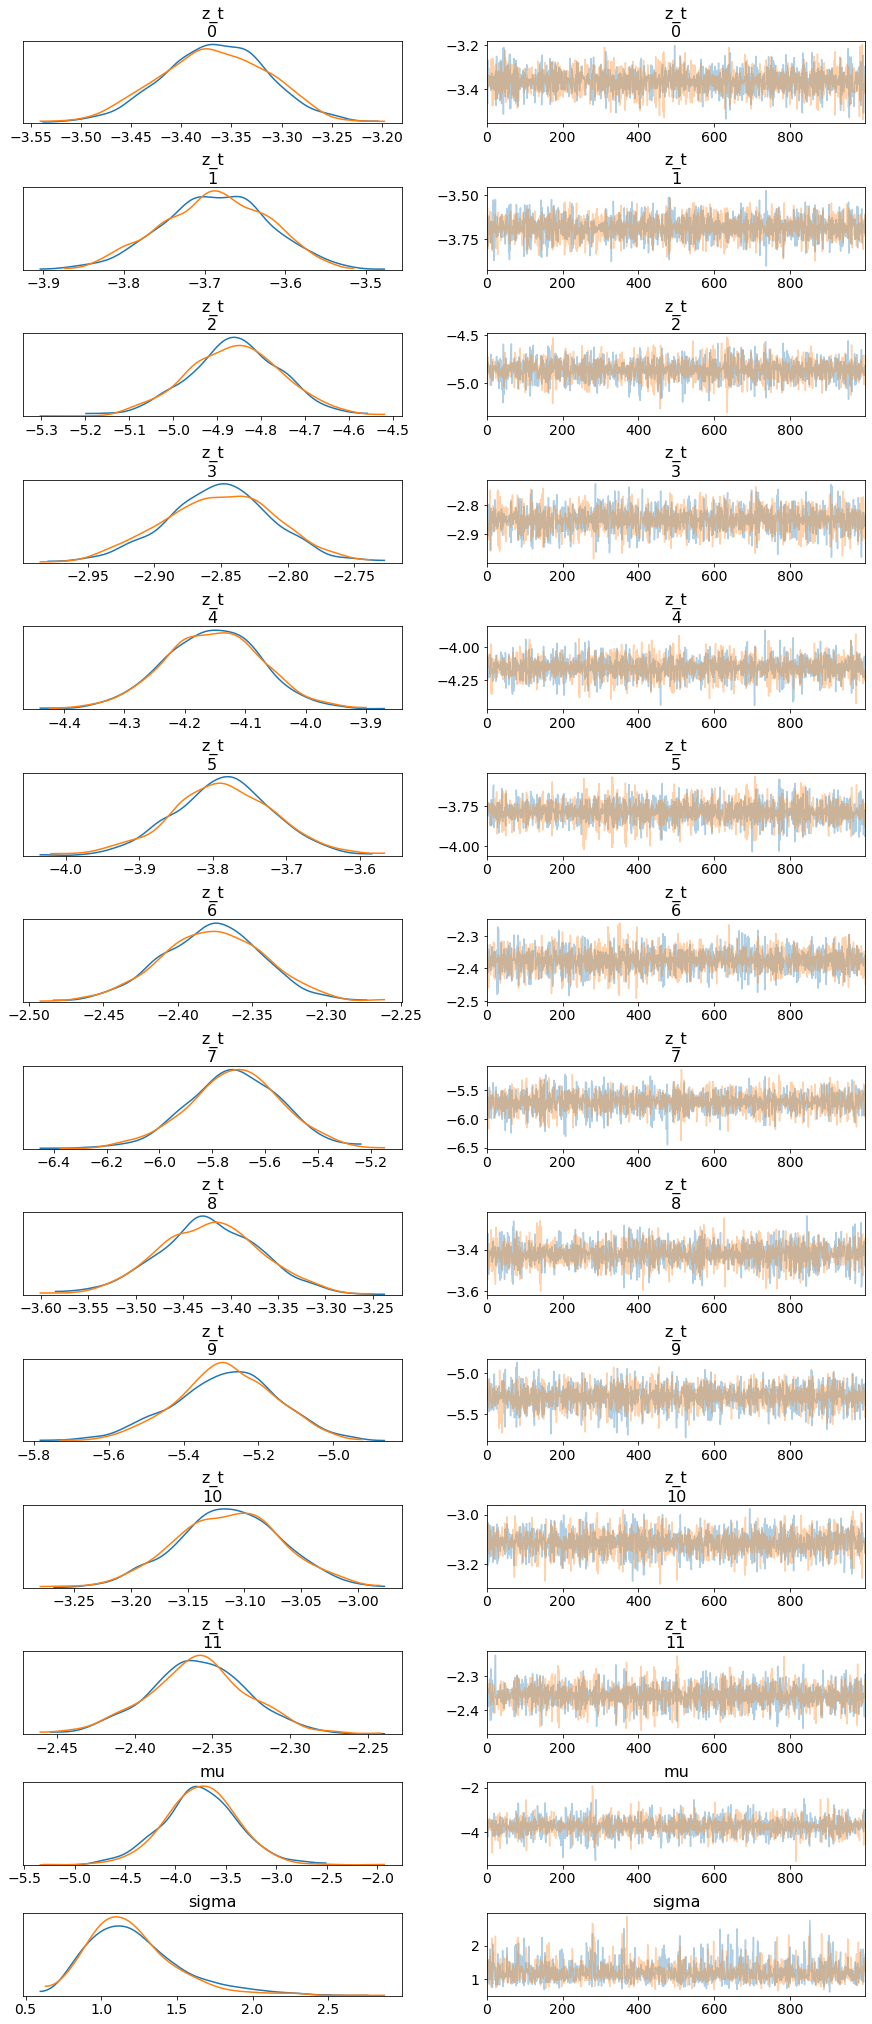

In [6]:
pm.traceplot(trace);

Dispersed prior led $\mu$ over-estimated and $\sigma$ under-estimated.   
The mean of prior $E(\mu)=-5$ seems to lead the posterior mean toward 0.  
$ E(\sigma)= 9/12 \approx 0.75$ and the posterior sigma is less than the true value.

In [7]:
# For EDA
def plot_data_timeseries(ys, xs=None, xlabel="Month", ylabel="Overdoses", new_plot=True, color="#E14A33", label=None):
    
    '''
    brief intro: plot 95 and IQR
    parameters:
    -----
    ys: sample size by time numpy array 
    xs: x axis as time
    xlabel: string
    ylabel: string
    new_plot: boolean
        plotting to a new figure or not
    color: str
    label: str
    return
    -----
    
    
    '''
    if xs is None:
        xs = np.arange(1,ys.shape[1]+1)
    
    if new_plot: plt.figure;
        # if we wanna make a new plot, then by using plt.figure function,
        # we create a new plot figure
        
    lc, liqr, m, uiqr, uc = np.percentile(ys, [2.5,25,50,75,97.5], axis=0);
    # now it's time to use the (already) existing plot figure
    plt.fill_between(xs, lc, uc,alpha=0.2 ,color=color);
    plt.fill_between(xs, liqr, uiqr, color=color, alpha=0.2);
    plt.plot(xs,m, color= color, label = label);
    plt.xlabel(xlabel);plt.ylabel(ylabel);

# Ambulance Call-outs

$n_{A}$: sample size   
$x_{A}$: the total number who confirmed they did call an ambulance  
$p_{A}$: probability of a person call an ambulance   

$$x_{A} \sim Bin(n_{A},p_{A})$$

We assume $n_{A}=0, 10, 100, 1000$ 
Suppose the prior of p is noninformative. 
$p(p) \sim Beta(1,1)$

(I got lost what can we do here with x and n for posterior of p)  
Assume that there was a survey that $n_A$ was the sample size of it.   
The true value of $p_A$ is postulated 0.8.  
We further suppose the people of the number of $x_A$ called the ambulance when the witnessed overdoses.   

In [8]:
# Generate simulated data
p_a_dflt = 0.8
np.random.binomial

In [17]:
def ambulance_callouts(p_a=p_a_dflt, n_a=0):
    # Generate simulated data
    x_data = np.random.binomial(n=n_a, p=p_a)
    
    # model definition
    with pm.Model() as model:
        p_a = pm.Beta('p_a', alpha=1, beta=1)
        x_a = pm.Binomial('x_a', n=n_a, p=p_a, observed=x_data)
        
    return model

In [18]:
model_list =[] # two iterate objs!
trace_list=[]
ppc_list=[]
for i,j in enumerate([0,10,100,1000]):
    model = ambulance_callouts(n_a=j)
    model_list.append(model)
    with model_list[i]:
        trace = pm.sample(1000)
        trace_list.append(trace)
        ppc = pm.sample_posterior_predictive(trace)
        ppc_list.append(ppc)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_a]
100%|██████████| 2000/2000 [00:01<00:00, 1867.71it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_a]
100%|██████████| 2000/2000 [00:00<00:00, 2297.36it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_a]
100%|██████████| 2000/2000 [00:00<00:00, 2209.81it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_a]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:01<00:00, 2189.49draws/s]
The acceptance probability does not match the target. It is 0.8840988216013687, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 2000/2000 [00:00<00:00, 2223.64it/s]


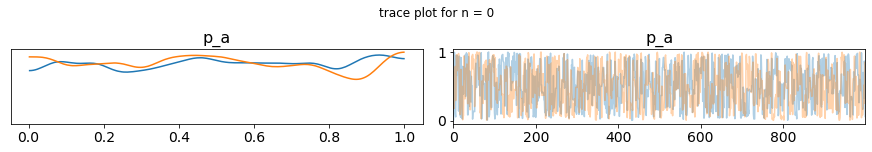

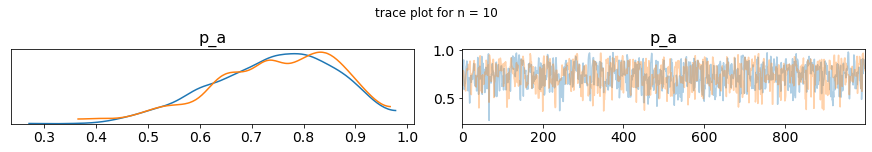

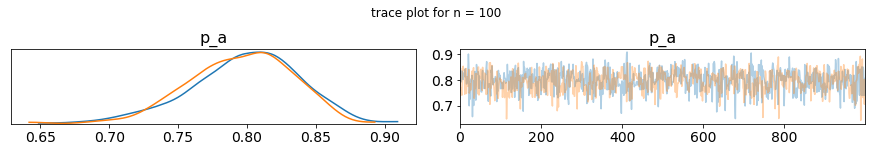

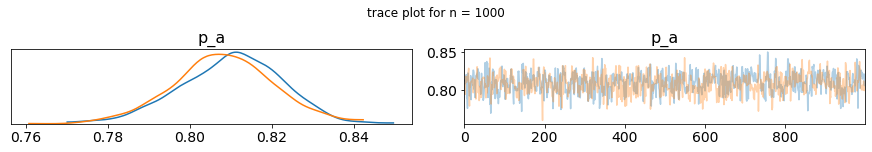

In [19]:
# fig, axs=plt.subplots(4,2)
for i,j in enumerate([0,10,100,1000]):
    pm.traceplot(trace_list[i], trace_kwargs={'label':'label not showing'})
    plt.gcf().suptitle('trace plot for n = {}'.format(j));
# YEAH!!!!

Now we get more real, we only have $U_t$ and $O_t$ is unknown and our ultimate interest of estimation.

$$ U_t \sim Bin(O_t, p_A)$$

In [30]:
u_t_data = o_t*p_a_dflt
print(u_t.shape)

(12,)


Let's start with the simplest model 

In [59]:
x_data = np.random.binomial(n=100, p=0.8)
with pm.Model() as p_a_model:
        # Ambulance model
        p_ambulance = pm.Beta('p_a', alpha=1, beta=1)
        x_a = pm.Binomial('x_a', n=100, p=p_ambulance, observed = x_data)
        trace_p_a = pm.sample(1000, chains=3)
    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [p_a]
Sampling 3 chains: 100%|██████████| 4500/4500 [00:02<00:00, 1714.15draws/s]
The acceptance probability does not match the target. It is 0.8816804893480766, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c272e9d90>,
      dtype=object)

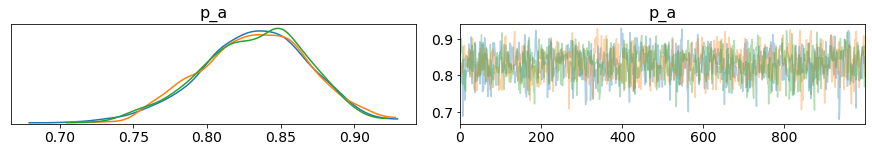

In [60]:
pm.traceplot(trace_p_a)

In [66]:
with pm.Model() as u_t_model:
    mu= pm.Uniform('mu', lower=-10, upper = 10)
    sigma= pm.Uniform('sigma', 0,3)
    z_t =pm.Normal('z_t',mu=mu, sigma=sigma, shape = (12,))
    o_t = pm.Poisson('o_t', mu=tt.exp(z_t)*N, shape=(12,))

    # Likelihood
    u_t = pm.Binomial('u_t', n=o_t, p=np.reshape(trace_p_a['p_a'], (int(3000/12),12)), observed=u_t_data)

ValueError: Input dimension mis-match. (input[0].shape[1] = 12, input[1].shape[1] = 1000)

In [43]:
type(trace_p_a['p_a'])

numpy.ndarray

In [62]:
trace_p_a['p_a'].shape

(3000,)

In [63]:
int(3000/12)*12

3000

In [67]:
np.reshape(trace_p_a['p_a'], (int(3000/12),12)).shape

(250, 12)

In [106]:

def ambulance_combined(p_a=p_a_dflt, n_a=0):
    x_data = np.random.binomial(n=n_a, p=p_a_dflt)
    # model definition
    with pm.Model() as p_a_model:
        # Ambulance model
        p_ambulance = pm.Beta('p_a', alpha=1, beta=1)
        x_a = pm.Binomial('x_a', n=n_a, p=p_ambulance, observed = x_data)
        
    with pm.Model() as u_t_model:
        # Overdose model 
        mu = pm.Uniform('mu', lower = -10, upper= 0)
        sigma = pm.Uniform('sigma', lower = 0, upper= 3)
        z_t =pm.Normal('z_t',mu=mu, sigma=sigma, shape = (12,))
        o_t = pm.Poisson('o_t', mu=tt.exp(z_t)*N, shape=(12,))
        

        
        # Likelihood
        u_t = pm.Binomial('u_t', n=o_t, p=p_ambulance, observed=u_t_data)
        
    return model

In [107]:
model = ambulance_combined(0.8,10)
with model:
    trace =pm.sample(1000)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [p_a, z_t, sigma, mu]
>Metropolis: [o_t]
Sampling 2 chains:   0%|          | 0/3000 [00:00<?, ?draws/s]INFO (theano.gof.compilelock): Waiting for existing lock by process '49133' (I am process '49134')
INFO (theano.gof.compilelock): To manually release the lock, delete /Users/hyeongcheolpark/.theano/compiledir_Darwin-19.0.0-x86_64-i386-64bit-i386-3.7.4-64/lock_dir
/Users/hyeongcheolpark/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling 2 chains:   0%|          | 0/3000 [00:09<?, ?draws/s]
Bad initial energy, check any log probabilities that are inf or -inf, nan or very small:
x_a   -inf


ParallelSamplingError: Bad initial energy

/Users/hyeongcheolpark/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
